In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px

import spacy
import nltk
from nltk.corpus import stopwords
import glob
from spacy.lang.en import English
from nltk.stem import WordNetLemmatizer

#Gensim
import gensim
from gensim.utils import simple_preprocess


from tqdm import tqdm
import re
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split, StratifiedKFold, KFold

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost.sklearn import XGBClassifier


from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score



C:\Users\Asus\Anaconda\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


Problem Statement - To predict the name of the company based on the text of the tweet.

In [47]:
df = pd.read_csv("twcs.csv")
df

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
0,1,sprintcare,False,Tue Oct 31 22:10:47 +0000 2017,@115712 I understand. I would like to assist y...,2,3.0
1,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1.0
2,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messag...,1,4.0
3,4,sprintcare,False,Tue Oct 31 21:54:49 +0000 2017,@115712 Please send us a Private Message so th...,3,5.0
4,5,115712,True,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6.0
...,...,...,...,...,...,...,...
2811769,2987947,sprintcare,False,Wed Nov 22 08:43:51 +0000 2017,"@823869 Hey, we'd be happy to look into this f...",NaN,2987948.0
2811770,2987948,823869,True,Wed Nov 22 08:35:16 +0000 2017,@115714 wtf!? I’ve been having really shitty s...,2987947,NaN
2811771,2812240,121673,True,Thu Nov 23 04:13:07 +0000 2017,@143549 @sprintcare You have to go to https://...,NaN,2812239.0
2811772,2987949,AldiUK,False,Wed Nov 22 08:31:24 +0000 2017,"@823870 Sounds delicious, Sarah! 😋 https://t.c...",NaN,2987950.0


In [48]:
df.isnull().sum()

tweet_id                         0
author_id                        0
inbound                          0
created_at                       0
text                             0
response_tweet_id          1040629
in_response_to_tweet_id     794335
dtype: int64

Below are the Tweets tweet by Company

In [49]:
df_company = df[df['inbound'] == False]
df_company


,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
0,1,sprintcare,False,Tue Oct 31 22:10:47 +0000 2017,@115712 I understand. I would like to assist y...,2,3.0
3,4,sprintcare,False,Tue Oct 31 21:54:49 +0000 2017,@115712 Please send us a Private Message so th...,3,5.0
5,6,sprintcare,False,Tue Oct 31 21:46:24 +0000 2017,@115712 Can you please send us a private messa...,"5,7",8.0
7,11,sprintcare,False,Tue Oct 31 22:10:35 +0000 2017,@115713 This is saddening to hear. Please shoo...,NaN,12.0
9,15,sprintcare,False,Tue Oct 31 20:03:31 +0000 2017,@115713 We understand your concerns and we'd l...,12,16.0
...,...,...,...,...,...,...,...
2811764,2987943,AirAsiaSupport,False,Wed Nov 22 07:54:57 +0000 2017,"@823868 Sorry but kindly try to clear browser,...",NaN,2987944.0
2811766,139628,ArgosHelpers,False,Wed Nov 22 08:03:26 +0000 2017,@134664 Can you Dm us your order number and we...,NaN,139627.0
2811767,2987945,VirginTrains,False,Wed Nov 22 08:27:34 +0000 2017,@524544 That's a Peak service. The 09:56 is th...,NaN,2987946.0
2811769,2987947,sprintcare,False,Wed Nov 22 08:43:51 +0000 2017,"@823869 Hey, we'd be happy to look into this f...",NaN,2987948.0


Below are the Tweets tweet by Users.
So, I am going to use this dataset to build my model for company name prediction

In [51]:
df_tweets = df[df['inbound'] == True]
df_tweets

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
1,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1.0
2,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messag...,1,4.0
4,5,115712,True,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6.0
6,8,115712,True,Tue Oct 31 21:45:10 +0000 2017,@sprintcare is the worst customer service,"9,6,10",NaN
8,12,115713,True,Tue Oct 31 22:04:47 +0000 2017,@sprintcare You gonna magically change your co...,"11,13,14",15.0
...,...,...,...,...,...,...,...
2811765,2987944,823868,True,Wed Nov 22 07:43:36 +0000 2017,@AirAsiaSupport \n\nI am unable to do web chec...,2987943,NaN
2811768,2987946,524544,True,Wed Nov 22 08:25:48 +0000 2017,@VirginTrains Hope you are well? Does the 9.30...,2987945,NaN
2811770,2987948,823869,True,Wed Nov 22 08:35:16 +0000 2017,@115714 wtf!? I’ve been having really shitty s...,2987947,NaN
2811771,2812240,121673,True,Thu Nov 23 04:13:07 +0000 2017,@143549 @sprintcare You have to go to https://...,NaN,2812239.0


In [59]:
company_name = df_company['author_id'].unique().tolist()
print("There are total {} company present in the dataset".format(len(company_name)))

There are total 108 company present in the dataset


lets extract the all names of company present in dataset

In [60]:
final_list = []

for name in company_name:
    new_name = "@"+name
    final_list.append(new_name)

In [61]:
final_list

['@sprintcare',
 '@Ask_Spectrum',
 '@VerizonSupport',
 '@ChipotleTweets',
 '@AskPlayStation',
 '@marksandspencer',
 '@MicrosoftHelps',
 '@ATVIAssist',
 '@AdobeCare',
 '@AmazonHelp',
 '@XboxSupport',
 '@AirbnbHelp',
 '@nationalrailenq',
 '@AirAsiaSupport',
 '@Morrisons',
 '@NikeSupport',
 '@AskAmex',
 '@McDonalds',
 '@YahooCare',
 '@AskLyft',
 '@UPSHelp',
 '@Delta',
 '@AppleSupport',
 '@Uber_Support',
 '@Tesco',
 '@SpotifyCares',
 '@British_Airways',
 '@comcastcares',
 '@AmericanAir',
 '@TMobileHelp',
 '@VirginTrains',
 '@SouthwestAir',
 '@AskeBay',
 '@hulu_support',
 '@GWRHelp',
 '@sainsburys',
 '@AskPayPal',
 '@HPSupport',
 '@ChaseSupport',
 '@CoxHelp',
 '@DropboxSupport',
 '@VirginAtlantic',
 '@BofA_Help',
 '@AzureSupport',
 '@AlaskaAir',
 '@ArgosHelpers',
 '@Postmates_Help',
 '@AskTarget',
 '@GoDaddyHelp',
 '@CenturyLinkHelp',
 '@AskPapaJohns',
 '@SW_Help',
 '@askpanera',
 '@Walmart',
 '@USCellularCares',
 '@AsurionCares',
 '@GloCare',
 '@idea_cares',
 '@DoorDash_Help',
 '@NeweggSer

Below Function will be use to create training Data for Custom NER Model.

In [62]:
def create_training_data(data, type):
    patterns = []
    for item in data:
        pattern = {
                    "label": type,
                    "pattern": item
                    }
        patterns.append(pattern)
    return (patterns)

patterns = create_training_data(final_list ,"Company")


In [63]:
patterns

[{'label': 'Company', 'pattern': '@sprintcare'},
 {'label': 'Company', 'pattern': '@Ask_Spectrum'},
 {'label': 'Company', 'pattern': '@VerizonSupport'},
 {'label': 'Company', 'pattern': '@ChipotleTweets'},
 {'label': 'Company', 'pattern': '@AskPlayStation'},
 {'label': 'Company', 'pattern': '@marksandspencer'},
 {'label': 'Company', 'pattern': '@MicrosoftHelps'},
 {'label': 'Company', 'pattern': '@ATVIAssist'},
 {'label': 'Company', 'pattern': '@AdobeCare'},
 {'label': 'Company', 'pattern': '@AmazonHelp'},
 {'label': 'Company', 'pattern': '@XboxSupport'},
 {'label': 'Company', 'pattern': '@AirbnbHelp'},
 {'label': 'Company', 'pattern': '@nationalrailenq'},
 {'label': 'Company', 'pattern': '@AirAsiaSupport'},
 {'label': 'Company', 'pattern': '@Morrisons'},
 {'label': 'Company', 'pattern': '@NikeSupport'},
 {'label': 'Company', 'pattern': '@AskAmex'},
 {'label': 'Company', 'pattern': '@McDonalds'},
 {'label': 'Company', 'pattern': '@YahooCare'},
 {'label': 'Company', 'pattern': '@AskLyft

lets build our Custom NER model using Spacy Library.

In [64]:
def generate_rules(patterns):
    nlp = English()
    ruler = nlp.add_pipe("entity_ruler")
    ruler.add_patterns(patterns)
    nlp.to_disk("hp_ner")

generate_rules(patterns)

In [65]:
nlp = spacy.load("hp_ner")

using below code we will extract the company username present in the tweet that extracted username will be act as a target label, we have also extracted the index as well bcoz there are certain tweets where user did't mentioned the company name

In [70]:
target = []
index = []


for text, i in tqdm(zip(df_tweets['text'], df_tweets.index)):
    doc = nlp(text)
    
    for ent in doc.ents:
        ans = ent.text
        target.append(ans)
        index.append(i)
        
        
        
    
    

1537843it [07:09, 3584.37it/s]


In [72]:
df_final = df_tweets.loc[index]
df_final

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
1,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1.0
2,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messag...,1,4.0
4,5,115712,True,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6.0
6,8,115712,True,Tue Oct 31 21:45:10 +0000 2017,@sprintcare is the worst customer service,"9,6,10",NaN
8,12,115713,True,Tue Oct 31 22:04:47 +0000 2017,@sprintcare You gonna magically change your co...,"11,13,14",15.0
...,...,...,...,...,...,...,...
2811763,2987942,823867,True,Wed Nov 22 07:30:39 +0000 2017,Hai @AirAsiaSupport #asking how many days need...,2987941,NaN
2811765,2987944,823868,True,Wed Nov 22 07:43:36 +0000 2017,@AirAsiaSupport \n\nI am unable to do web chec...,2987943,NaN
2811768,2987946,524544,True,Wed Nov 22 08:25:48 +0000 2017,@VirginTrains Hope you are well? Does the 9.30...,2987945,NaN
2811771,2812240,121673,True,Thu Nov 23 04:13:07 +0000 2017,@143549 @sprintcare You have to go to https://...,NaN,2812239.0


In [73]:
df_final['Organization'] = target

In [74]:
df_final

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id,Organization
1,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1.0,@sprintcare
2,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messag...,1,4.0,@sprintcare
4,5,115712,True,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6.0,@sprintcare
6,8,115712,True,Tue Oct 31 21:45:10 +0000 2017,@sprintcare is the worst customer service,"9,6,10",NaN,@sprintcare
8,12,115713,True,Tue Oct 31 22:04:47 +0000 2017,@sprintcare You gonna magically change your co...,"11,13,14",15.0,@sprintcare
...,...,...,...,...,...,...,...,...
2811763,2987942,823867,True,Wed Nov 22 07:30:39 +0000 2017,Hai @AirAsiaSupport #asking how many days need...,2987941,NaN,@AirAsiaSupport
2811765,2987944,823868,True,Wed Nov 22 07:43:36 +0000 2017,@AirAsiaSupport \n\nI am unable to do web chec...,2987943,NaN,@AirAsiaSupport
2811768,2987946,524544,True,Wed Nov 22 08:25:48 +0000 2017,@VirginTrains Hope you are well? Does the 9.30...,2987945,NaN,@VirginTrains
2811771,2812240,121673,True,Thu Nov 23 04:13:07 +0000 2017,@143549 @sprintcare You have to go to https://...,NaN,2812239.0,@sprintcare


Our dataset is ready for Preprocessing

In [75]:
final =[]

for org in df_final['Organization']:
    final.append(org.split('@')[1])
    
df_final['Organization'] = final

In [76]:
df_final.reset_index(inplace=True)


In [77]:
df_final.columns

Index(['index', 'tweet_id', 'author_id', 'inbound', 'created_at', 'text',
       'response_tweet_id', 'in_response_to_tweet_id', 'Organization'],
      dtype='object')

In [78]:
df_final.drop(['index', 'tweet_id', 'author_id', 'inbound', 'created_at',
       'response_tweet_id', 'in_response_to_tweet_id'], axis=1, inplace=True )

In [79]:
df_final

,text,Organization
0,@sprintcare and how do you propose we do that,sprintcare
1,@sprintcare I have sent several private messag...,sprintcare
2,@sprintcare I did.,sprintcare
3,@sprintcare is the worst customer service,sprintcare
4,@sprintcare You gonna magically change your co...,sprintcare
...,...,...
1176983,Hai @AirAsiaSupport #asking how many days need...,AirAsiaSupport
1176984,@AirAsiaSupport \n\nI am unable to do web chec...,AirAsiaSupport
1176985,@VirginTrains Hope you are well? Does the 9.30...,VirginTrains
1176986,@143549 @sprintcare You have to go to https://...,sprintcare


In [81]:
df_final.duplicated(subset='text', keep='first').sum()

55820

In [82]:
print("There are total {} number of Duplicates present in our dataset".format(df_final.duplicated(subset='text', keep='first').sum()))
df_final.drop_duplicates(inplace=True)

There are total 55820 number of Duplicates present in our dataset


After Removing Duplicates.....

In [84]:
df_final

,text,Organization
0,@sprintcare and how do you propose we do that,sprintcare
1,@sprintcare I have sent several private messag...,sprintcare
2,@sprintcare I did.,sprintcare
3,@sprintcare is the worst customer service,sprintcare
4,@sprintcare You gonna magically change your co...,sprintcare
...,...,...
1176983,Hai @AirAsiaSupport #asking how many days need...,AirAsiaSupport
1176984,@AirAsiaSupport \n\nI am unable to do web chec...,AirAsiaSupport
1176985,@VirginTrains Hope you are well? Does the 9.30...,VirginTrains
1176986,@143549 @sprintcare You have to go to https://...,sprintcare


lets make some preprocessing on data

1) Remove any type of username present in a text

2) Remove Hashtags

3) Remove any kind or urls

4) Remove Numbers

5) lowering the text

In [85]:
corpus = []
for text in tqdm(df_final['text']):
    review= re.sub("@([a-zA-Z0-9_]{1,50})"," ", text).strip() #remove username
    review = re.sub("#[A-Za-z0-9_]+"," ", review).strip() #remove hashtags
    review= re.sub(r'http\S+', ' ', review).strip() #remove links
    review = re.sub('[^a-zA-Z]', ' ', review).strip()
    review = review.lower()
    review = review.strip("\n").strip(" ")
    corpus.append(review)
    

100%|█████████████████████████████████████████████████████████████████████| 1133828/1133828 [00:26<00:00, 43147.16it/s]


In [87]:
print("There are total {} number of records present in the dataset ".format(len(corpus)))

There are total 1133828 number of records present in the dataset 


In [88]:
df_final['Corpus'] = corpus

In [89]:
df_final

,text,Organization,Corpus
0,@sprintcare and how do you propose we do that,sprintcare,and how do you propose we do that
1,@sprintcare I have sent several private messag...,sprintcare,i have sent several private messages and no on...
2,@sprintcare I did.,sprintcare,i did
3,@sprintcare is the worst customer service,sprintcare,is the worst customer service
4,@sprintcare You gonna magically change your co...,sprintcare,you gonna magically change your connectivity f...
...,...,...,...
1176983,Hai @AirAsiaSupport #asking how many days need...,AirAsiaSupport,hai how many days needed to proceed cancel...
1176984,@AirAsiaSupport \n\nI am unable to do web chec...,AirAsiaSupport,i am unable to do web checkin i am getting t...
1176985,@VirginTrains Hope you are well? Does the 9.30...,VirginTrains,hope you are well does the am train from ...
1176986,@143549 @sprintcare You have to go to https://...,sprintcare,you have to go to and ask them to add the hu...


Remove those words which have length less than equal to 3

In [90]:
df_final['Corpus'] = df_final['Corpus'].apply(lambda x:" ".join([w for w in x.split() if len(w)>3]))

In [91]:
df_final

,text,Organization,Corpus
0,@sprintcare and how do you propose we do that,sprintcare,propose that
1,@sprintcare I have sent several private messag...,sprintcare,have sent several private messages responding ...
2,@sprintcare I did.,sprintcare,
3,@sprintcare is the worst customer service,sprintcare,worst customer service
4,@sprintcare You gonna magically change your co...,sprintcare,gonna magically change your connectivity whole...
...,...,...,...
1176983,Hai @AirAsiaSupport #asking how many days need...,AirAsiaSupport,many days needed proceed cancelation flight th...
1176984,@AirAsiaSupport \n\nI am unable to do web chec...,AirAsiaSupport,unable checkin getting below error please chec...
1176985,@VirginTrains Hope you are well? Does the 9.30...,VirginTrains,hope well does train from crewe euston class p...
1176986,@143549 @sprintcare You have to go to https://...,sprintcare,have them hulu service your account after text...


Remove top 15 very common words in dataset which doesnt give much information

In [92]:
#common words

from collections import Counter
cnt = Counter()
for text in df_final["Corpus"].values:
    for word in text.split():
        cnt[word] += 1
        
cnt.most_common(15)

[('this', 165873),
 ('have', 160919),
 ('that', 149700),
 ('with', 124910),
 ('your', 118141),
 ('from', 93779),
 ('just', 91291),
 ('what', 75744),
 ('thanks', 71597),
 ('when', 71218),
 ('they', 69637),
 ('help', 66328),
 ('been', 63594),
 ('will', 62194),
 ('please', 60860)]

In [93]:
FREQWORDS = set([w for (w, wc) in cnt.most_common(15)])
def remove_freqwords(text):
    """custom function to remove the frequent words"""
    return " ".join([word for word in str(text).split() if word not in FREQWORDS])

df_final["Corpus"] = df_final["Corpus"].apply(lambda text: remove_freqwords(text))
df_final.head()

#This Code Taken from Stack Overflow

,text,Organization,Corpus
0,@sprintcare and how do you propose we do that,sprintcare,propose
1,@sprintcare I have sent several private messag...,sprintcare,sent several private messages responding usual
2,@sprintcare I did.,sprintcare,
3,@sprintcare is the worst customer service,sprintcare,worst customer service
4,@sprintcare You gonna magically change your co...,sprintcare,gonna magically change connectivity whole family


Remove top 15 very Rare words in dataset.

In [94]:
n_rare_words = 15
RAREWORDS = set([w for (w, wc) in cnt.most_common()[:-n_rare_words-1:-1]])
def remove_rarewords(text):
    """custom function to remove the rare words"""
    return " ".join([word for word in str(text).split() if word not in RAREWORDS])

df_final["Corpus"] = df_final["Corpus"].apply(lambda text: remove_rarewords(text))
df_final.head()

#This Code Taken from Stack Overflow

,text,Organization,Corpus
0,@sprintcare and how do you propose we do that,sprintcare,propose
1,@sprintcare I have sent several private messag...,sprintcare,sent several private messages responding usual
2,@sprintcare I did.,sprintcare,
3,@sprintcare is the worst customer service,sprintcare,worst customer service
4,@sprintcare You gonna magically change your co...,sprintcare,gonna magically change connectivity whole family


Lemetization of sentences by keeping only Noun, Adejective, Verb, Adverb

In [96]:
def lemmatization(texts, allowed_postags=["NOUN", "ADJ", "VERB", "ADV"]):
    nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
    texts_out = []
    for text in tqdm(texts):
        doc = nlp(text)
        new_text = []
        for token in doc:
            if token.pos_ in allowed_postags:
                new_text.append(token.lemma_)
        final = " ".join(new_text)
        texts_out.append(final)
    return (texts_out)


lemmatized_texts = lemmatization(df_final['Corpus'])
# print (lemmatized_texts[0][0:90])

100%|█████████████████████████████████████████████████████████████████████| 1133828/1133828 [1:15:59<00:00, 248.68it/s]


In [97]:
df_final['lemma'] = lemmatized_texts

In [98]:
df_final

,text,Organization,Corpus,lemma
0,@sprintcare and how do you propose we do that,sprintcare,propose,propose
1,@sprintcare I have sent several private messag...,sprintcare,sent several private messages responding usual,send several private message respond usual
2,@sprintcare I did.,sprintcare,,
3,@sprintcare is the worst customer service,sprintcare,worst customer service,bad customer service
4,@sprintcare You gonna magically change your co...,sprintcare,gonna magically change connectivity whole family,gon magically change connectivity whole family
...,...,...,...,...
1176983,Hai @AirAsiaSupport #asking how many days need...,AirAsiaSupport,many days needed proceed cancelation flight th...,many day need proceed cancelation flight email...
1176984,@AirAsiaSupport \n\nI am unable to do web chec...,AirAsiaSupport,unable checkin getting below error check rever...,unable checkin get error check revert thank
1176985,@VirginTrains Hope you are well? Does the 9.30...,VirginTrains,hope well does train crewe euston class peak peak,hope do train crewe euston class peak peak
1176986,@143549 @sprintcare You have to go to https://...,sprintcare,them hulu service account after text good,hulu service account text good


In [99]:
def gen_words(texts):
    final = []
    for text in tqdm(texts):
        new = gensim.utils.simple_preprocess(text, deacc=True)
        final.append(new)
    return (final)

data_words = gen_words(df_final['lemma'])


100%|█████████████████████████████████████████████████████████████████████| 1133828/1133828 [00:39<00:00, 28962.84it/s]


Now we will find out Bigram and Trigrams present in our dataset

In [100]:
#BIGRAMS AND TRIGRAMS
bigram_phrases = gensim.models.Phrases(data_words, min_count=5, threshold=100)
trigram_phrases = gensim.models.Phrases(bigram_phrases[data_words], threshold=100)

bigram = gensim.models.phrases.Phraser(bigram_phrases)
trigram = gensim.models.phrases.Phraser(trigram_phrases)

def make_bigrams(texts):
    return([bigram[doc] for doc in tqdm(texts)])

def make_trigrams(texts):
    return ([trigram[bigram[doc]] for doc in tqdm(texts)])

data_bigrams = make_bigrams(data_words)
data_bigrams_trigrams = make_trigrams(data_bigrams)

#This code is taken from Stackoverflow


100%|█████████████████████████████████████████████████████████████████████| 1133828/1133828 [00:28<00:00, 40377.59it/s]


In [101]:
data_bigrams_trigrams

[['propose'],
 ['send', 'several', 'private', 'message', 'respond', 'usual'],
 [],
 ['bad', 'customer', 'service'],
 ['gon', 'magically', 'change', 'connectivity', 'whole', 'family'],
 ['sign'],
 ['like', 'email', 'copy', 'spectrum', 'update', 'training'],
 ['receive', 'corporate', 'office', 'like', 'copy'],
 ['correct',
  'account',
  'takeover',
  'email',
  'consent',
  'form',
  'do',
  'need',
  'do',
  'local',
  'office'],
 ['incorrect',
  'information',
  'form',
  'front',
  'fax',
  'maybe',
  'need',
  'maintain',
  'date',
  'information'],
 ['customer',
  'service',
  'rep',
  'super',
  'nice',
  'imma',
  'start',
  'trippin',
  'service',
  'go'],
 ['picture', 'pretty', 'much', 'month'],
 ['finally', 'help'],
 ['meeeeee', 'have', 'bad', 'luck', 'customer', 'service'],
 ['friend',
  'internet',
  'need',
  'play',
  'videogame',
  'together',
  'skill',
  'diminish',
  'moment',
  'internetz'],
 ['else', 'provide', 'refuse', 'validate', 'account'],
 ['phone',
  'number',

In [102]:
df_final['data_bigrams_trigrams'] = data_bigrams_trigrams

In [103]:
df_final

,text,Organization,Corpus,lemma,data_bigrams_trigrams
0,@sprintcare and how do you propose we do that,sprintcare,propose,propose,[propose]
1,@sprintcare I have sent several private messag...,sprintcare,sent several private messages responding usual,send several private message respond usual,"[send, several, private, message, respond, usual]"
2,@sprintcare I did.,sprintcare,,,[]
3,@sprintcare is the worst customer service,sprintcare,worst customer service,bad customer service,"[bad, customer, service]"
4,@sprintcare You gonna magically change your co...,sprintcare,gonna magically change connectivity whole family,gon magically change connectivity whole family,"[gon, magically, change, connectivity, whole, ..."
...,...,...,...,...,...
1176983,Hai @AirAsiaSupport #asking how many days need...,AirAsiaSupport,many days needed proceed cancelation flight th...,many day need proceed cancelation flight email...,"[many, day, need, proceed, cancelation, flight..."
1176984,@AirAsiaSupport \n\nI am unable to do web chec...,AirAsiaSupport,unable checkin getting below error check rever...,unable checkin get error check revert thank,"[unable, checkin, get, error, check, revert, t..."
1176985,@VirginTrains Hope you are well? Does the 9.30...,VirginTrains,hope well does train crewe euston class peak peak,hope do train crewe euston class peak peak,"[hope, do, train, crewe, euston, class, peak, ..."
1176986,@143549 @sprintcare You have to go to https://...,sprintcare,them hulu service account after text good,hulu service account text good,"[hulu, service, account, text, good]"


In [104]:
# df_final.to_csv("Preprocessed.csv")

In [4]:
df_final = pd.read_csv('Preprocessed.csv')

In [5]:
df_final

,Unnamed: 0,text,Organization,Corpus,lemma,data_bigrams_trigrams
0,0,@sprintcare and how do you propose we do that,sprintcare,propose,propose,['propose']
1,1,@sprintcare I have sent several private messag...,sprintcare,sent several private messages responding usual,send several private message respond usual,"['send', 'several', 'private', 'message', 'res..."
2,2,@sprintcare I did.,sprintcare,NaN,NaN,[]
3,3,@sprintcare is the worst customer service,sprintcare,worst customer service,bad customer service,"['bad', 'customer', 'service']"
4,4,@sprintcare You gonna magically change your co...,sprintcare,gonna magically change connectivity whole family,gon magically change connectivity whole family,"['gon', 'magically', 'change', 'connectivity',..."
...,...,...,...,...,...,...
1133823,1176983,Hai @AirAsiaSupport #asking how many days need...,AirAsiaSupport,many days needed proceed cancelation flight th...,many day need proceed cancelation flight email...,"['many', 'day', 'need', 'proceed', 'cancelatio..."
1133824,1176984,@AirAsiaSupport \n\nI am unable to do web chec...,AirAsiaSupport,unable checkin getting below error check rever...,unable checkin get error check revert thank,"['unable', 'checkin', 'get', 'error', 'check',..."
1133825,1176985,@VirginTrains Hope you are well? Does the 9.30...,VirginTrains,hope well does train crewe euston class peak peak,hope do train crewe euston class peak peak,"['hope', 'do', 'train', 'crewe', 'euston', 'cl..."
1133826,1176986,@143549 @sprintcare You have to go to https://...,sprintcare,them hulu service account after text good,hulu service account text good,"['hulu', 'service', 'account', 'text', 'good']"


In [6]:
df_final.drop(['text','Corpus','lemma', 'Unnamed: 0'], axis=1, inplace=True)

In [7]:
df_final

,Organization,data_bigrams_trigrams
0,sprintcare,['propose']
1,sprintcare,"['send', 'several', 'private', 'message', 'res..."
2,sprintcare,[]
3,sprintcare,"['bad', 'customer', 'service']"
4,sprintcare,"['gon', 'magically', 'change', 'connectivity',..."
...,...,...
1133823,AirAsiaSupport,"['many', 'day', 'need', 'proceed', 'cancelatio..."
1133824,AirAsiaSupport,"['unable', 'checkin', 'get', 'error', 'check',..."
1133825,VirginTrains,"['hope', 'do', 'train', 'crewe', 'euston', 'cl..."
1133826,sprintcare,"['hulu', 'service', 'account', 'text', 'good']"


There are certain rows where empty lists are present, lets delete them

In [8]:
df_final.drop(df_final[df_final['data_bigrams_trigrams']=='[]'].index, axis=0, inplace=True)

In [9]:
df_final

,Organization,data_bigrams_trigrams
0,sprintcare,['propose']
1,sprintcare,"['send', 'several', 'private', 'message', 'res..."
3,sprintcare,"['bad', 'customer', 'service']"
4,sprintcare,"['gon', 'magically', 'change', 'connectivity',..."
5,sprintcare,['sign']
...,...,...
1133823,AirAsiaSupport,"['many', 'day', 'need', 'proceed', 'cancelatio..."
1133824,AirAsiaSupport,"['unable', 'checkin', 'get', 'error', 'check',..."
1133825,VirginTrains,"['hope', 'do', 'train', 'crewe', 'euston', 'cl..."
1133826,sprintcare,"['hulu', 'service', 'account', 'text', 'good']"


In [10]:
from ast import literal_eval

df_final['lis'] = df_final.data_bigrams_trigrams.apply(literal_eval)

In [11]:
df_final

,Organization,data_bigrams_trigrams,lis
0,sprintcare,['propose'],[propose]
1,sprintcare,"['send', 'several', 'private', 'message', 'res...","[send, several, private, message, respond, usual]"
3,sprintcare,"['bad', 'customer', 'service']","[bad, customer, service]"
4,sprintcare,"['gon', 'magically', 'change', 'connectivity',...","[gon, magically, change, connectivity, whole, ..."
5,sprintcare,['sign'],[sign]
...,...,...,...
1133823,AirAsiaSupport,"['many', 'day', 'need', 'proceed', 'cancelatio...","[many, day, need, proceed, cancelation, flight..."
1133824,AirAsiaSupport,"['unable', 'checkin', 'get', 'error', 'check',...","[unable, checkin, get, error, check, revert, t..."
1133825,VirginTrains,"['hope', 'do', 'train', 'crewe', 'euston', 'cl...","[hope, do, train, crewe, euston, class, peak, ..."
1133826,sprintcare,"['hulu', 'service', 'account', 'text', 'good']","[hulu, service, account, text, good]"


lets find number of words present in every record after preprocessing

In [12]:
length = []
for index in df_final['lis'].index:
    length.append(len(df_final['lis'][index]))
    
df_final['Number_of_word'] = length
    

In [13]:
df_final

,Organization,data_bigrams_trigrams,lis,Number_of_word
0,sprintcare,['propose'],[propose],1
1,sprintcare,"['send', 'several', 'private', 'message', 'res...","[send, several, private, message, respond, usual]",6
3,sprintcare,"['bad', 'customer', 'service']","[bad, customer, service]",3
4,sprintcare,"['gon', 'magically', 'change', 'connectivity',...","[gon, magically, change, connectivity, whole, ...",6
5,sprintcare,['sign'],[sign],1
...,...,...,...,...
1133823,AirAsiaSupport,"['many', 'day', 'need', 'proceed', 'cancelatio...","[many, day, need, proceed, cancelation, flight...",12
1133824,AirAsiaSupport,"['unable', 'checkin', 'get', 'error', 'check',...","[unable, checkin, get, error, check, revert, t...",7
1133825,VirginTrains,"['hope', 'do', 'train', 'crewe', 'euston', 'cl...","[hope, do, train, crewe, euston, class, peak, ...",8
1133826,sprintcare,"['hulu', 'service', 'account', 'text', 'good']","[hulu, service, account, text, good]",5


In [14]:
df_final['Number_of_word'].unique()

array([ 1,  6,  3,  5, 11, 10,  4,  2,  8,  7,  9, 12, 22, 32, 13, 16, 17,
       18, 21, 15, 14, 19, 23, 20, 25, 24, 27, 26, 28, 31, 30, 29, 47, 33,
       34, 45], dtype=int64)

<AxesSubplot:xlabel='Number_of_word', ylabel='count'>

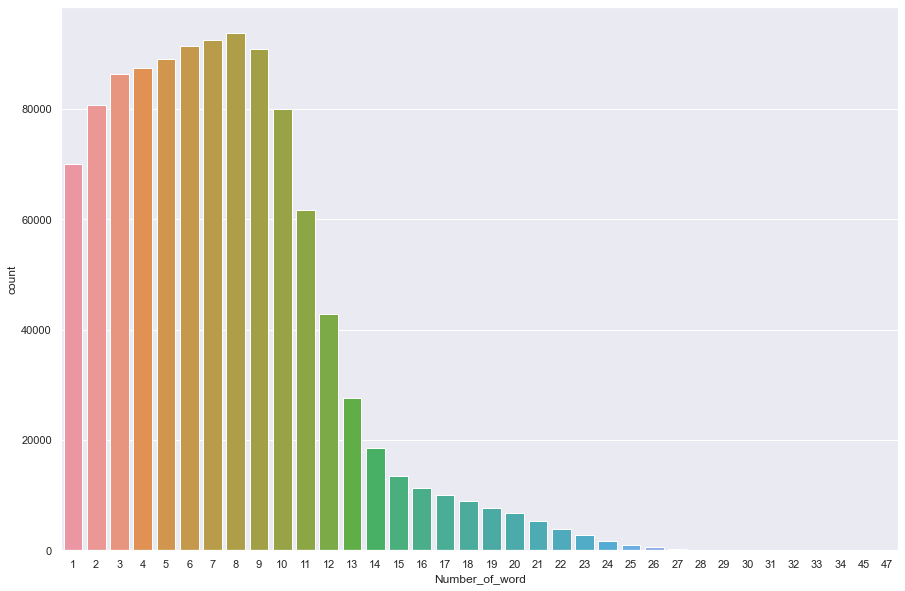

In [15]:
sns.set(rc={'figure.figsize':(15,10)})
sns.countplot(x="Number_of_word", data=df_final)

we are only considering those record where atleast 5 words are present

In [16]:
df_final = df_final[df_final['Number_of_word']>=5]
df_final.shape

(762159, 4)

In [17]:
# df_final.to_csv('preprocessed11.csv')

In [18]:
df_final = pd.read_csv("preprocessed11.csv")
df_final

,Unnamed: 0,Organization,data_bigrams_trigrams,lis,Number_of_word
0,1,sprintcare,"['send', 'several', 'private', 'message', 'res...","['send', 'several', 'private', 'message', 'res...",6
1,4,sprintcare,"['gon', 'magically', 'change', 'connectivity',...","['gon', 'magically', 'change', 'connectivity',...",6
2,6,Ask_Spectrum,"['like', 'email', 'copy', 'spectrum', 'update'...","['like', 'email', 'copy', 'spectrum', 'update'...",6
3,7,Ask_Spectrum,"['receive', 'corporate', 'office', 'like', 'co...","['receive', 'corporate', 'office', 'like', 'co...",5
4,8,Ask_Spectrum,"['correct', 'account', 'takeover', 'email', 'c...","['correct', 'account', 'takeover', 'email', 'c...",11
...,...,...,...,...,...
762154,1133823,AirAsiaSupport,"['many', 'day', 'need', 'proceed', 'cancelatio...","['many', 'day', 'need', 'proceed', 'cancelatio...",12
762155,1133824,AirAsiaSupport,"['unable', 'checkin', 'get', 'error', 'check',...","['unable', 'checkin', 'get', 'error', 'check',...",7
762156,1133825,VirginTrains,"['hope', 'do', 'train', 'crewe', 'euston', 'cl...","['hope', 'do', 'train', 'crewe', 'euston', 'cl...",8
762157,1133826,sprintcare,"['hulu', 'service', 'account', 'text', 'good']","['hulu', 'service', 'account', 'text', 'good']",5


<AxesSubplot:xlabel='Organization', ylabel='count'>

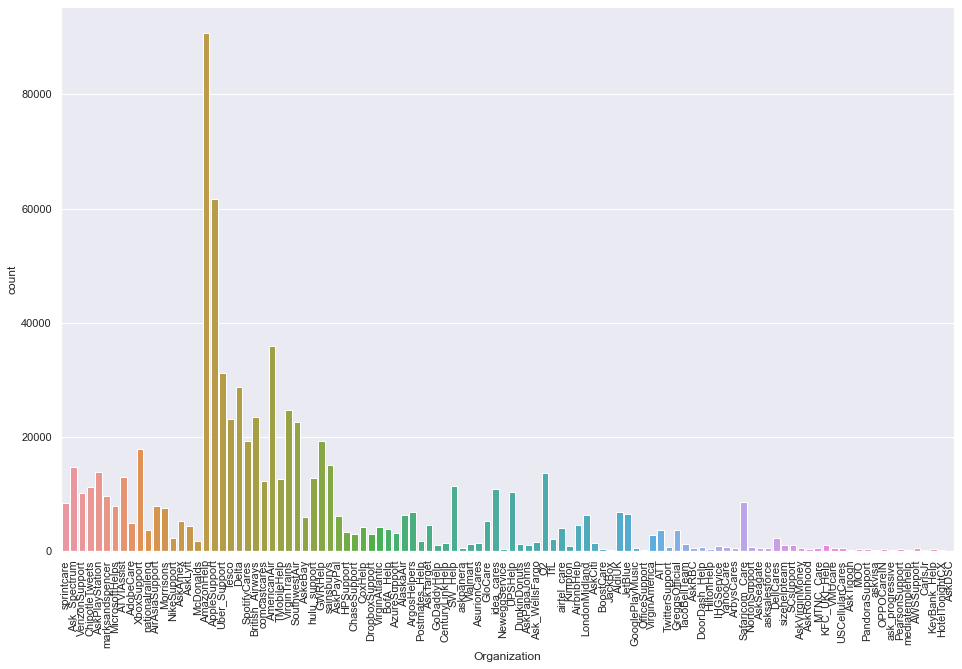

In [19]:
fig = plt.gcf()
fig.set_size_inches( 16, 10)
plt.xticks(rotation=90)
sns.countplot(x="Organization", data=df_final)

Dataset is Highly Imbalanced and there are 108 labels

lets Consider Top5 companies/organization based on their value counts

In [20]:
top5 = df_final['Organization'].value_counts().head(5).index.tolist()
top5


['AmazonHelp', 'AppleSupport', 'AmericanAir', 'Uber_Support', 'Delta']

In [21]:
df_final = df_final.loc[df_final['Organization'].isin(top5)]
df_final


,Unnamed: 0,Organization,data_bigrams_trigrams,lis,Number_of_word
80,143,AmazonHelp,"['different', 'people', 'give', 'different', '...","['different', 'people', 'give', 'different', '...",11
81,144,AmazonHelp,"['frankly', 'patience', 'chat', 'customer', 's...","['frankly', 'patience', 'chat', 'customer', 's...",7
82,146,AmazonHelp,"['crazy', 'less', 'week', 'away', 'still', 'sh...","['crazy', 'less', 'week', 'away', 'still', 'sh...",10
83,147,AmazonHelp,"['order', 'local', 'courier', 'last', 'day', '...","['order', 'local', 'courier', 'last', 'day', '...",10
84,151,AmazonHelp,"['buy', 'echo', 'show', 'recognize', 'single',...","['buy', 'echo', 'show', 'recognize', 'single',...",8
...,...,...,...,...,...
762110,1133762,AmericanAir,"['blatant', 'sexism', 'aside', 'tell', 'do', '...","['blatant', 'sexism', 'aside', 'tell', 'do', '...",9
762111,1133763,AmericanAir,"['do', 'still', 'suck', 'international', 'trip...","['do', 'still', 'suck', 'international', 'trip...",8
762112,1133764,AmericanAir,"['seriously', 'time', 'airline', 'change', 'ru...","['seriously', 'time', 'airline', 'change', 'ru...",10
762113,1133766,AmericanAir,"['look', 'mistake', 'time', 'same', 'divert']","['look', 'mistake', 'time', 'same', 'divert']",5


In [22]:
df_final.reset_index(inplace=True)

In [23]:
df_final

,index,Unnamed: 0,Organization,data_bigrams_trigrams,lis,Number_of_word
0,80,143,AmazonHelp,"['different', 'people', 'give', 'different', '...","['different', 'people', 'give', 'different', '...",11
1,81,144,AmazonHelp,"['frankly', 'patience', 'chat', 'customer', 's...","['frankly', 'patience', 'chat', 'customer', 's...",7
2,82,146,AmazonHelp,"['crazy', 'less', 'week', 'away', 'still', 'sh...","['crazy', 'less', 'week', 'away', 'still', 'sh...",10
3,83,147,AmazonHelp,"['order', 'local', 'courier', 'last', 'day', '...","['order', 'local', 'courier', 'last', 'day', '...",10
4,84,151,AmazonHelp,"['buy', 'echo', 'show', 'recognize', 'single',...","['buy', 'echo', 'show', 'recognize', 'single',...",8
...,...,...,...,...,...,...
248182,762110,1133762,AmericanAir,"['blatant', 'sexism', 'aside', 'tell', 'do', '...","['blatant', 'sexism', 'aside', 'tell', 'do', '...",9
248183,762111,1133763,AmericanAir,"['do', 'still', 'suck', 'international', 'trip...","['do', 'still', 'suck', 'international', 'trip...",8
248184,762112,1133764,AmericanAir,"['seriously', 'time', 'airline', 'change', 'ru...","['seriously', 'time', 'airline', 'change', 'ru...",10
248185,762113,1133766,AmericanAir,"['look', 'mistake', 'time', 'same', 'divert']","['look', 'mistake', 'time', 'same', 'divert']",5


Convert text data into vectors using Tfidf Vectoriser...

we can also use countvectoriser as well but Tfidf Vectoriser has its own advantage

In [41]:
vectorizer = TfidfVectorizer( ngram_range=(1, 3), min_df=7, max_features=12000)
X = vectorizer.fit_transform(df_final['data_bigrams_trigrams'])
y = df_final.Organization
    

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

In [44]:
def train_test_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    accuracy = model.score(X_test, y_test)
    precision = precision_score(y_test, predictions, average='weighted')
    recall = recall_score(y_test, predictions, average='weighted')
    fscore= f1_score(y_test, predictions, average='weighted')
    
    return predictions, accuracy, precision, recall, fscore

### Naive Bayes

In [74]:
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
nb_model = MultinomialNB(alpha=0)



predictions_nb, accuracy_nb, precision_nb, recall_nb, fscore_nb = train_test_model(nb_model, X_train, X_test, y_train, y_test)

accuracy1 = []
precision1 = []
recall1 = []
fscore1 = []

for train_index, test_index in skfold.split(X,y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    nb_model.fit(X_train, y_train)
    predictions = nb_model.predict(X_test)
    accuracy = nb_model.score(X_test, y_test)
    precision= precision_score(y_test, predictions, average='weighted')
    recall = recall_score(y_test, predictions, average='weighted')
    fscore = f1_score(y_test, predictions, average='weighted')
    
    accuracy1.append(accuracy)
    precision1.append(precision)
    recall1.append(recall)
    fscore1.append(fscore)
    
avg_accuracy1 = (sum(accuracy1)/len(accuracy1))
avg_precision1 = (sum(precision1)/len(precision1))
avg_recall1 = (sum(recall1)/len(recall1))
avg_fscore1 = (sum(fscore1)/len(fscore1))


    
    





C:\Users\Asus\Anaconda\lib\site-packages\sklearn\naive_bayes.py:508: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '
C:\Users\Asus\Anaconda\lib\site-packages\sklearn\naive_bayes.py:508: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '
C:\Users\Asus\Anaconda\lib\site-packages\sklearn\naive_bayes.py:508: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '
C:\Users\Asus\Anaconda\lib\site-packages\sklearn\naive_bayes.py:508: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '
C:\Users\Asus\Anaconda\lib\site-packages\sklearn\naive_bayes.py:508: UserWarning: alpha too small will result in numeric err

In [88]:
# # initialise data of lists.
data = {'Evaluation_Type':['Normal', 'Normal', 'Normal', 'Normal',"CV", "CV","CV","CV"],
        'Metrics':["Accuracy", "Precision", "Recall", "F1Score","Accuracy", "Precision", "Recall", "F1Score"],
       "Score":[accuracy_nb, precision_nb, recall_nb, fscore_nb,avg_accuracy1,avg_precision1, avg_recall1,avg_fscore1]}
 
# Create DataFrame
df_nb = pd.DataFrame(data)
 
# Print the output.
df_nb

,Evaluation_Type,Metrics,Score
0,Normal,Accuracy,0.784234
1,Normal,Precision,0.780794
2,Normal,Recall,0.784234
3,Normal,F1Score,0.778138
4,CV,Accuracy,0.784598
5,CV,Precision,0.780917
6,CV,Recall,0.784598
7,CV,F1Score,0.778259


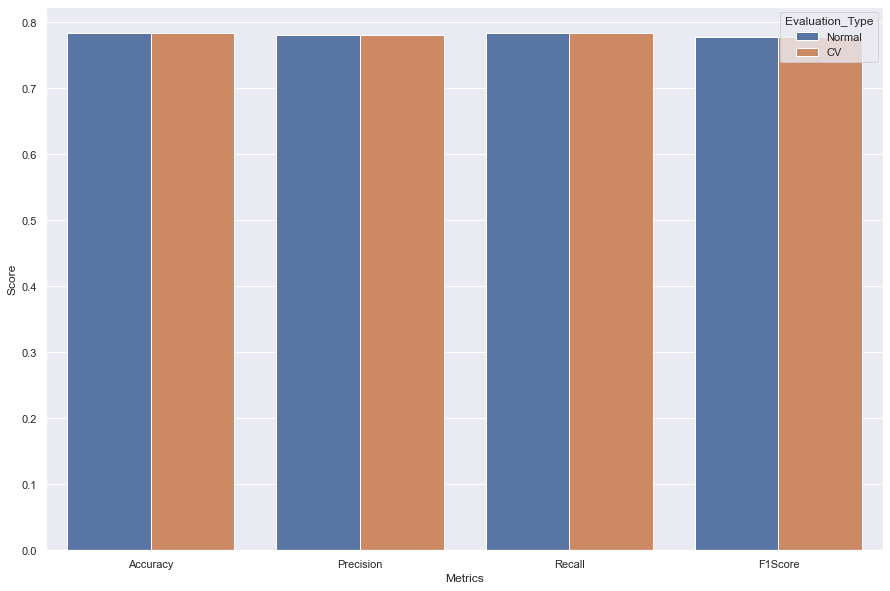

In [89]:
ax = sns.barplot(x="Metrics", y="Score", hue="Evaluation_Type", data=df_nb)

## Logistic Regression

In [76]:
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
Lg_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', penalty='l2', C=1.0, max_iter=1000)




predictions_Lg, accuracy_Lg, precision_Lg, recall_Lg, fscore_Lg = train_test_model(Lg_model, X_train, X_test, y_train, y_test)

accuracy1 = []
precision1 = []
recall1 = []
fscore1 = []

for train_index, test_index in skfold.split(X,y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    Lg_model.fit(X_train, y_train)
    predictions = Lg_model.predict(X_test)
    accuracy = Lg_model.score(X_test, y_test)
    precision= precision_score(y_test, predictions, average='weighted')
    recall = recall_score(y_test, predictions, average='weighted')
    fscore = f1_score(y_test, predictions, average='weighted')
    
    accuracy1.append(accuracy)
    precision1.append(precision)
    recall1.append(recall)
    fscore1.append(fscore)
    
avg_accuracy2=(sum(accuracy1)/len(accuracy1))
avg_precision2 = (sum(precision1)/len(precision1))
avg_recall2 = (sum(recall1)/len(recall1))
avg_fscore2 = (sum(fscore1)/len(fscore1))

In [90]:
# # initialise data of lists.
data = {'Evaluation_Type':['Normal', 'Normal', 'Normal', 'Normal',"CV", "CV","CV","CV"],
        'Metrics':["Accuracy", "Precision", "Recall", "F1Score","Accuracy", "Precision", "Recall", "F1Score"],
       "Score":[accuracy_Lg, precision_Lg, recall_Lg, fscore_Lg, avg_accuracy2,avg_precision2, avg_recall2,avg_fscore2]}
 
# Create DataFrame
df_lg = pd.DataFrame(data)
 
# Print the output.
df_lg

,Evaluation_Type,Metrics,Score
0,Normal,Accuracy,0.798880
1,Normal,Precision,0.793935
2,Normal,Recall,0.798880
3,Normal,F1Score,0.793340
4,CV,Accuracy,0.800086
5,CV,Precision,0.795196
6,CV,Recall,0.800086
7,CV,F1Score,0.794436


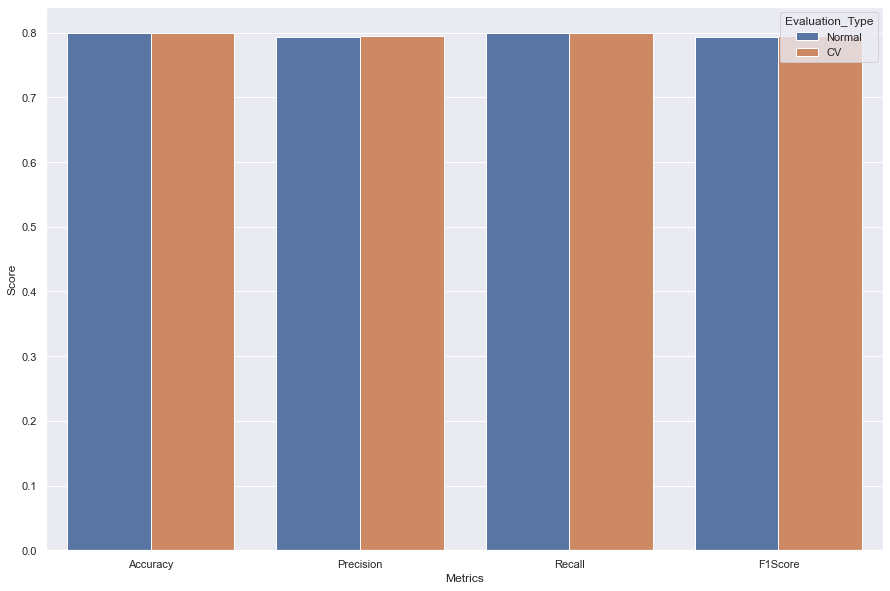

In [91]:
ax = sns.barplot(x="Metrics", y="Score", hue="Evaluation_Type", data=df_lg)

### Xg Boost

In [79]:
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
Xg_model = XGBClassifier(objective='multi:softmax',scale_pos_weight=10000)




predictions_Xg, accuracy_Xg, precision_Xg, recall_Xg, fscore_Xg = train_test_model(Xg_model, X_train, X_test, y_train, y_test)

accuracy1 = []
precision1 = []
recall1 = []
fscore1 = []

for train_index, test_index in skfold.split(X,y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    Xg_model.fit(X_train, y_train)
    predictions = Xg_model.predict(X_test)
    accuracy = Xg_model.score(X_test, y_test)
    precision= precision_score(y_test, predictions, average='weighted')
    recall = recall_score(y_test, predictions, average='weighted')
    fscore = f1_score(y_test, predictions, average='weighted')
    
    accuracy1.append(accuracy)
    precision1.append(precision)
    recall1.append(recall)
    fscore1.append(fscore)
    
avg_accuracy3 = (sum(accuracy1)/len(accuracy1))
avg_precision3 = (sum(precision1)/len(precision1))
avg_recall3=(sum(recall1)/len(recall1))
avg_fscore3=(sum(fscore1)/len(fscore1))

C:\Users\Asus\Anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:21:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "scale_pos_weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:21:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Asus\Anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:23:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "scale_pos_weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:23:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Asus\Anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:25:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "scale_pos_weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:25:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Asus\Anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:27:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "scale_pos_weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:27:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Asus\Anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:29:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "scale_pos_weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:30:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Asus\Anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:32:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "scale_pos_weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:32:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [92]:
# # initialise data of lists.
data = {'Evaluation_Type':['Normal', 'Normal', 'Normal', 'Normal',"CV", "CV","CV","CV"],
        'Metrics':["Accuracy", "Precision", "Recall", "F1Score","Accuracy", "Precision", "Recall", "F1Score"],
       "Score":[accuracy_Xg, precision_Xg, recall_Xg, fscore_Xg,avg_accuracy3,avg_precision3, avg_recall3,avg_fscore3]}
 
# Create DataFrame
df_xg = pd.DataFrame(data)
 
# Print the output.
df_xg

,Evaluation_Type,Metrics,Score
0,Normal,Accuracy,0.758970
1,Normal,Precision,0.765151
2,Normal,Recall,0.758970
3,Normal,F1Score,0.745751
4,CV,Accuracy,0.760386
5,CV,Precision,0.766371
6,CV,Recall,0.760386
7,CV,F1Score,0.747389


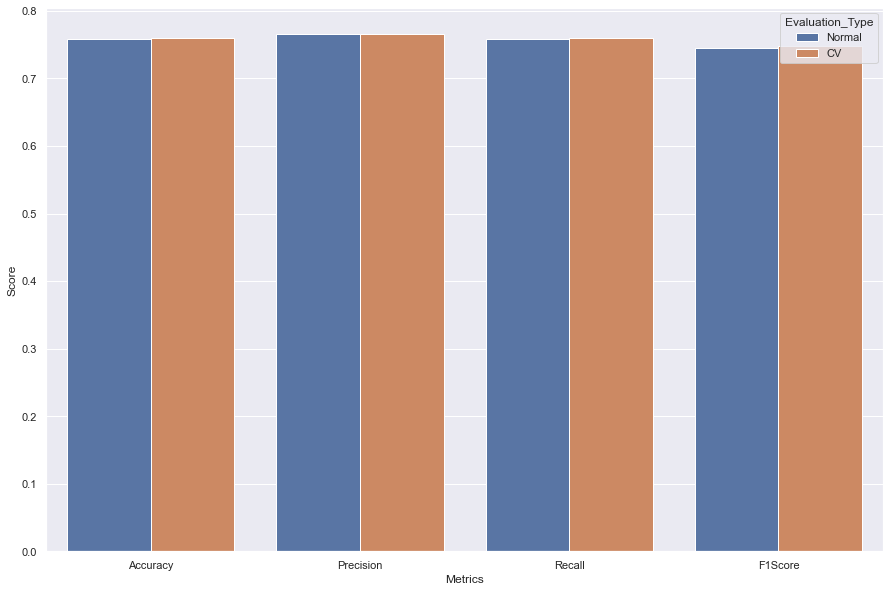

In [93]:
ax = sns.barplot(x="Metrics", y="Score", hue="Evaluation_Type", data=df_xg)

## Random Forest

In [80]:
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
Rf_model = RandomForestClassifier(n_estimators=100, max_depth=100, min_samples_split=10, n_jobs=-1, verbose=0)



predictions_Rf, accuracy_Rf, precision_Rf, recall_Rf, fscore_Rf = train_test_model(Rf_model, X_train, X_test, y_train, y_test)

accuracy1 = []
precision1 = []
recall1 = []
fscore1 = []

for train_index, test_index in skfold.split(X,y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    Rf_model.fit(X_train, y_train)
    predictions = Rf_model.predict(X_test)
    accuracy = Rf_model.score(X_test, y_test)
    precision= precision_score(y_test, predictions, average='weighted')
    recall = recall_score(y_test, predictions, average='weighted')
    fscore = f1_score(y_test, predictions, average='weighted')
    
    accuracy1.append(accuracy)
    precision1.append(precision)
    recall1.append(recall)
    fscore1.append(fscore)
    

    
avg_accuracy4 = (sum(accuracy1)/len(accuracy1))
avg_precision4 = (sum(precision1)/len(precision1))
avg_recall4 = (sum(recall1)/len(recall1))
avg_fscore4 = (sum(fscore1)/len(fscore1))

In [94]:
# # initialise data of lists.
data = {'Evaluation_Type':['Normal', 'Normal', 'Normal', 'Normal',"CV", "CV","CV","CV"],
        'Metrics':["Accuracy", "Precision", "Recall", "F1Score","Accuracy", "Precision", "Recall", "F1Score"],
       "Score":[accuracy_Rf, precision_Rf, recall_Rf, fscore_Rf,avg_accuracy4,avg_precision4, avg_recall4,avg_fscore4]}
 
# Create DataFrame
df_Rf = pd.DataFrame(data)
 
# Print the output.
df_Rf

,Evaluation_Type,Metrics,Score
0,Normal,Accuracy,0.743518
1,Normal,Precision,0.761969
2,Normal,Recall,0.743518
3,Normal,F1Score,0.723825
4,CV,Accuracy,0.746268
5,CV,Precision,0.763690
6,CV,Recall,0.746268
7,CV,F1Score,0.726873


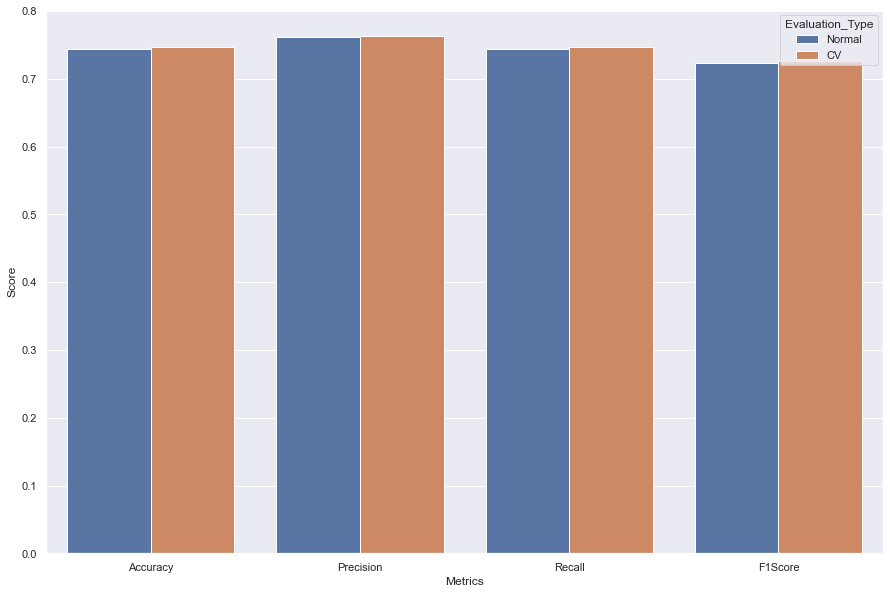

In [95]:
ax = sns.barplot(x="Metrics", y="Score", hue="Evaluation_Type", data=df_Rf)

## SVM

In [81]:
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
svc_model = LinearSVC(class_weight='balanced', verbose=False, max_iter=10000, tol=1e-4, C=0.1)



predictions_svc, accuracy_svc, precision_svc, recall_svc, fscore_svc = train_test_model(svc_model, X_train, X_test, y_train, y_test)

accuracy1 = []
precision1 = []
recall1 = []
fscore1 = []

for train_index, test_index in skfold.split(X,y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    svc_model.fit(X_train, y_train)
    predictions = svc_model.predict(X_test)
    accuracy = svc_model.score(X_test, y_test)
    precision= precision_score(y_test, predictions, average='weighted')
    recall = recall_score(y_test, predictions, average='weighted')
    fscore = f1_score(y_test, predictions, average='weighted')
    
    accuracy1.append(accuracy)
    precision1.append(precision)
    recall1.append(recall)
    fscore1.append(fscore)
    

    
avg_accuracy5 = (sum(accuracy1)/len(accuracy1))
avg_precision5 = (sum(precision1)/len(precision1))
avg_recall5=(sum(recall1)/len(recall1))
avg_fscore5 = (sum(fscore1)/len(fscore1))

In [96]:
# # initialise data of lists.
data = {'Evaluation_Type':['Normal', 'Normal', 'Normal', 'Normal',"CV", "CV","CV","CV"],
        'Metrics':["Accuracy", "Precision", "Recall", "F1Score","Accuracy", "Precision", "Recall", "F1Score"],
       "Score":[accuracy_svc, precision_svc, recall_svc, fscore_svc,avg_accuracy5,avg_precision5, avg_recall5,avg_fscore5]}
 
# Create DataFrame
df_svc = pd.DataFrame(data)
 
# Print the output.
df_svc

,Evaluation_Type,Metrics,Score
0,Normal,Accuracy,0.793682
1,Normal,Precision,0.792965
2,Normal,Recall,0.793682
3,Normal,F1Score,0.792494
4,CV,Accuracy,0.795626
5,CV,Precision,0.794571
6,CV,Recall,0.795626
7,CV,F1Score,0.794279


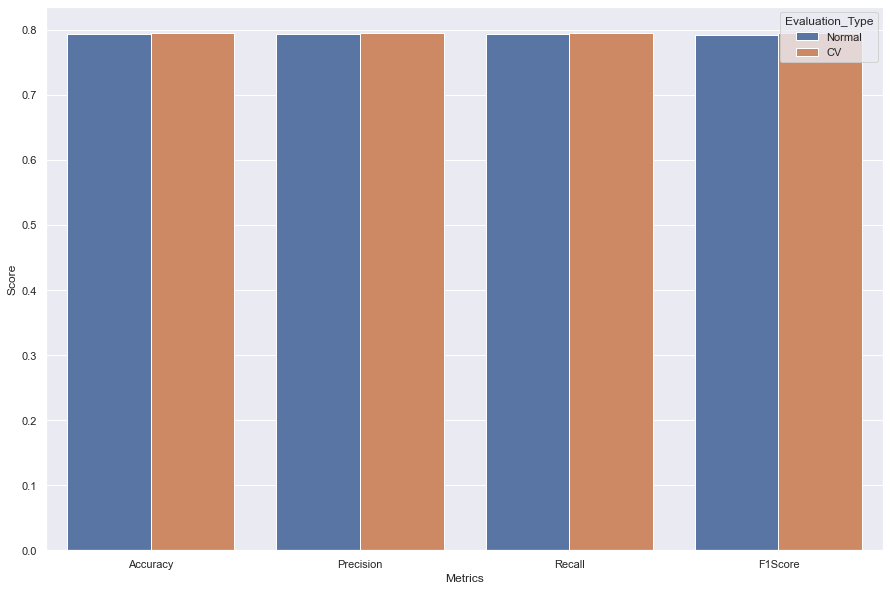

In [97]:
ax = sns.barplot(x="Metrics", y="Score", hue="Evaluation_Type", data=df_svc)

Observation:
    
    In all the above Models we almost got the same score for Normal and Kfold evaluation type 
    
    Now lets find which model perform well out of all Models

In [98]:
# # initialise data of lists.
data = {'Model':['NaiveBayes', 'Logistic Regression', 'XgBoost', 'RandomForest',"SVC"],
        'Accuracy':[avg_accuracy1, avg_accuracy2, avg_accuracy3, avg_accuracy4, avg_accuracy5],
       "Precision":[avg_precision1, avg_precision2, avg_precision3, avg_precision4,avg_precision5],
       "Recall":[avg_recall1, avg_recall2, avg_recall3, avg_recall4,avg_recall5],
       "F1Score":[avg_fscore1, avg_fscore2, avg_fscore3, avg_fscore4,avg_fscore5]}
 
# Create DataFrame
df_result = pd.DataFrame(data)
 
# Print the output.
df_result

,Model,Accuracy,Precision,Recall,F1Score
0,NaiveBayes,0.784598,0.780917,0.784598,0.778259
1,Logistic Regression,0.800086,0.795196,0.800086,0.794436
2,XgBoost,0.760386,0.766371,0.760386,0.747389
3,RandomForest,0.746268,0.763690,0.746268,0.726873
4,SVC,0.795626,0.794571,0.795626,0.794279


In [103]:
fig = px.line(df_result, x='Model', y='Accuracy', text="Accuracy", title='Cross Validation Accuracy Score for different models')
fig.show()

In [104]:
fig = px.line(df_result, x='Model', y='Precision', text="Precision", title='Precision Score for different models')
fig.show()

In [105]:
fig = px.line(df_result, x='Model', y='Recall', text="Recall", title='Recall Score for different models')
fig.show()

In [106]:
fig = px.line(df_result, x='Model', y='F1Score', text="F1Score", title='F1Score Score for different models')
fig.show()

Observation:
    
    Logistic Regression has Highest Accuracy, Precison, Recall and F1 Score